# Topic Classification

GPT-2 Model Experiment 1<br>
Topic classification of news articles written in Korean
- Data: [국립국어원 신문 말뭉치(v2)](https://corpus.korean.go.kr/) sampling data
- Model: [SKT AI KoGPT2](https://github.com/SKT-AI/KoGPT2) fine-tuning

Author: [Seongbum Seo](https://github.com/Seongbuming)

In [1]:
import torch
torch.cuda.empty_cache()

## Background Setup

In [2]:
# Install transformers library
%pip install -q git+https://github.com/huggingface/transformers.git
# Install helper functions
%pip install -q git+https://github.com/gmihaila/ml_things.git

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Clone base model
!git clone https://github.com/SKT-AI/KoGPT2
%pip install matplotlib==3.1.3

fatal: destination path 'KoGPT2' already exists and is not an empty directory.
     |████████████████████████████████| 13.1 MB 5.9 MB/s eta 0:00:01
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.2
    Uninstalling matplotlib-3.5.2:
      Successfully uninstalled matplotlib-3.5.2
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

ml-things 0.0.1 requires matplotlib>=3.4.0, but you'll have matplotlib 3.1.3 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


## Model Setup

In [4]:
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader, random_split
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed, TrainingArguments, Trainer, GPT2Config, GPT2Tokenizer, AdamW, get_linear_schedule_with_warmup, GPT2ForSequenceClassification)

# Set seed for reproducibility
set_seed(123)

# Number of training epochs (authors on fine-tuning Bert recommend between 2 and 4)
epochs = 4

# Number of batches - depending on the max sequence length and GPU memory
# For 512 sequence length batch of 10 works without cuda memory issues
# For small sequence length can try batch of 32 or higher
batch_size = 32

# Pad or truncate text sequences to a specific length
# If 'None' it will use maximum sequence of word piece tokens allowed by model
max_length = 60

# Look for GPU to use
# Will use 'cpu' by default if no GPU found
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Name of the base model to use
model_name_or_path = 'skt/kogpt2-base-v2'

# Path of data to use for training and validation
train_data_path = './data/sample_7000_3000/train'
test_data_path = './data/sample_7000_3000/validation'

# Dictionary of labels and their id - this will be used to convert string labels to number ids
labels_ids = {
    'ITscience': 0,
    'culture': 1,
    'economy': 2,
    'entertainment': 3,
    'health': 4,
    'life': 5,
    'politic': 6,
    'social': 7,
    'sport': 8
}

# List of label names
label_names = list(labels_ids.keys())

# Number of labels
n_labels = len(labels_ids)

/usr/local/lib/python3.8/dist-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/usr/local/lib/python3.8/dist-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.8/dist-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/usr/local/lib/python3.8/dist-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/usr/local/lib/python3.8/dist-packages/matplotlib/__init__.py:200: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module

## Data

In [5]:
class NewsDataset(Dataset):
    def __init__(self, path, use_tokenizer):
        # Check if path exists
        if not os.path.isdir(path):
            # Raise error if path is invalid
            raise ValueError('Invalid `path` variable. Needs to be a directory.')
        
        self.texts = []
        self.labels = []

        # Since the labels are defined by folders with data we loop through each label
        for label in label_names:
            sentiment_path = os.path.join(path, label)

            # Get all files from path
            files_names = os.listdir(sentiment_path)#[:10] # Sample for debugging
            # Go through each file and read its content
            for file_name in tqdm(files_names, desc=f'{label} files'):
                file_path = os.path.join(sentiment_path, file_name)

                # Read content
                content = io.open(file_path, mode='r', encoding='utf-8').read()
                # Fix any unicode issues
                content = fix_text(content)
                # Save content
                self.texts.append(content)
                # Save encode labels
                self.labels.append(label)
            
        # Number of examples
        self.n_examples = len(self.labels)
    
    def __len__(self):
        r'''When used `len` return the number of examples.
        '''
        
        return self.n_examples
    
    def __getitem__(self, item):
        r'''Given an index return an example from the position.
        
        Arguments:
            item(:obj:`int`):
                Index position to pick an example to return.
        
        Returns:
            :obj:`Dict[str, str]`: Dictionary of inputs that contain text and associated labels
        '''

        return {
            'text': self.texts[item],
            'label': self.labels[item]
        }

In [6]:
class Gpt2ClassificationCollator(object):
    r'''Data Collator used for GPT-2 in a classification rask.

    It uses a given tokenizer and label encoder to convert any text and labels to numbers that can go straight into a GPT-2 model.
    
    Arguments:
        use_tokenizer(:obj:`transformers.tokenization_?`):
            Transformer type tokenizer used to process raw text into numbers
        labels_encoder(:obj:`dict`):
            Dictionary to encode any labels names into numbers.
            Keys map to labels names and Values map to number associated to those labels.
        max_sequence_len(:obj:`int`, `optional`):
            Value to indicate the maximum desired sequence to truncate or pad text sequences.
            If no value is passed it will used maximum sequence size supported by the tokenizer and model.
    '''
    
    def __init__(self, use_tokenizer, labels_encoder, max_sequence_len=None):
        # Tokenizer to be used inside the class
        self.use_tokenizer = use_tokenizer
        # Check max sequence length
        self.max_sequence_len = use_tokenizer.model_max_length if max_sequence_len is None else max_sequence_len
        # Label encoder used inside the class
        self.labels_encoder = labels_encoder
    
    def __call__(self, sequences):
        r'''This function allowes the class object to be used as a function call.
        Sine the PyTorch DataLoader needs a collator function, I can use this class as a function.

        Arguments:
            item(:obj:`list`):
                List of texts and labels.
        
        Returns:
            :obj:`Dict[str, object]`: Dictionary of inputs that feed into the model.
            It holddes the statement `model(**Returned Dictionary)`.
        '''

        # Get all texts from sequences list
        texts = [sequence['text'] for sequence in sequences]
        # Get all labels from sequences list
        labels = [sequence['label'] for sequence in sequences]
        # Encode all labels using label encoder
        labels = [self.labels_encoder[label] for label in labels]
        # Call tokenizer on all texts to convert into tensors of numbers with appropriate padding
        inputs = self.use_tokenizer(text=texts, return_tensors='pt', padding=True, truncation=True, max_length=self.max_sequence_len)
        # Update the inputs with the associated encoded labels as tensor
        inputs.update({'labels': torch.tensor(labels)})
        
        return inputs

In [7]:
def train(dataloader, optimizer_, scheduler_, device_):
    r'''Train PyTorch model on a single pass through the data loader.
    
    It will use the global variable `model` which is the transformer model loaded on `device_` that we want to train on.
    
    Arguments:
        dataloader(:obj:`torch.utils.data.dataloader.DataLoader`):
            Parsed data into batches of tensors.
        optimizer_(:obj:`transformers.optimization.AdamW`):
            Optimizer used for training.
        scheduler_(:obj:`torch.optim.lr_scheduler.LambdaLR`):
            PyTorch scheduler.
        device_(:obj:`torch.device`):
            Device used to load tensors before feeding to model.
    
    Returns:
        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted Labels, Train Average Loss].
    '''
    
    # Use global variable for model
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch
    total_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data
    for batch in tqdm(dataloader, total=len(dataloader)):
        # Add original labels - use later for evaluation
        true_labels += batch['labels'].numpy().flatten().tolist()
        # Move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(**batch)

        # The call to `model` always returns a tuple, so we need to pull
        # the loss value out of the tuple along with the logits
        # We will use logits later to calculate training accuracy
        loss, logits = outputs[:2]
        # Accumulate the training loss over all of the batches so that we can
        # caculate the average loss at the end
        # The `loss` is a Tensor containing a single value
        # The `.item()` function just returns the Python value from the tensor
        total_loss += loss.item()
        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0
        # This is to help prevent the exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        # The optimizer dictates the update rule - how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer_.step()
        # Update the learning reate
        scheduler_.step()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        # Convert these logits to list of predicted labels values
        predictions_labels += logits.argmax(axis=-1).flatten().tolist()

    # Calculate the average loss over the training data
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediction for future evaluations
    return true_labels, predictions_labels, avg_epoch_loss

In [8]:
def validation(dataloader, device_):
    r'''Validation function to evaluate model performance on a separate set of data.
    
    This function will return the true and predicted labels so we can use later to evaluate the model's performance.
    
    Arguments:
        dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
            Parsed data into batches of tensors.
        device_(:obj:`torch.device`):
            Device used to load tensors before feeding to model.
    
    Return:
        :obj:`List[List[int], List[int], float]`: List of [True Labels, Predicted Labels, Train Average Loss]
    '''
    
    # Use global variable for model
    global model

    # Tracking variables
    predictions_labels = []
    true_labels = []
    # Total loss for this epoch
    total_loss = 0

    # Put the model in evaluation mode
    # - the dropout layers differently during evaluation
    model.eval()

    # Evaluate data for one epoch
    for batch in tqdm(dataloader, total=len(dataloader)):
        # Add original labels
        true_labels += batch['labels'].numpy().flatten().tolist()
        # Move batch to device
        batch = {k: v.type(torch.long).to(device_) for k, v in batch.items()}

        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            # This will return the logits rather than the loss because we have not provided labels
            # token_type_ids is the same as the 'segment ids', which differentiates sentence 1 and 2 in 2-sentence tasks
            outputs = model(**batch)
            
            # The call to `model` always returns a tuple, so we need to pull
            # the loss value out of the tuple along with the logits later to calculate training accuracy
            loss, logits = outputs[:2]
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end
            # The `loss` is the Tensor containing a single value
            # The `.item()` function just returns the Python value from the tensor
            total_loss += loss.item()

            # Get predictions to list
            predict_content = logits.argmax(axis=-1).flatten().tolist()
            # Update list
            predictions_labels += predict_content
    
    # Calculate the average loss over the training data
    avg_epoch_loss = total_loss / len(dataloader)

    # Return all true labels and prediction for future evaluations
    return true_labels, predictions_labels, avg_epoch_loss

## Model

In [9]:
# Get model configuration
print('Loading configuration...')
model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path=model_name_or_path, num_labels=n_labels)

# Get model's tokenizer
print('Loading tokenizer...')
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast.from_pretrained(
    model_name_or_path,
    bos_token='</s>',
    eos_token='</s>',
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>'
)
# Default to left padding
tokenizer.padding_side = 'left'
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token

# Get the actual model
print('Loading model...')
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path=model_name_or_path, config=model_config)

# Resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))
# Fix model padding token id
model.config.pad_token_id = model.config.eos_token_id
# Load model to define device
model.to(device)
print(f'Model loaded to `{device}`.')

Loading configuration...


Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

Loading tokenizer...


Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


Loading model...


Downloading:   0%|          | 0.00/490M [00:00<?, ?B/s]

Some weights of the model checkpoint at skt/kogpt2-base-v2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at skt/kogpt2-base-v2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded to `cuda`.


In [10]:
#train_dataset_size = int(len(dataset) * 0.6)
#valid_dataset_size = int(len(dataset) * 0.2)
#test_dataset_size = len(dataset) - train_dataset_size - valid_dataset_size
#train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_dataset_size, valid_dataset_size, test_dataset_size])

In [11]:
# Create data collator to encode text and labels into numbers
gpt2_classification_collator = Gpt2ClassificationCollator(
    use_tokenizer=tokenizer,
    labels_encoder=labels_ids,
    max_sequence_len=max_length
)

print('Dealing with train...')
# Create pytorch dataset
train_dataset = NewsDataset(path=train_data_path, use_tokenizer=tokenizer)
print(f'Created `train_dataset` with {len(train_dataset)} examples.')

# Move pytorch dataset into dataloder
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=gpt2_classification_collator)
print(f'Created `train_dataloader` with {len(train_dataloader)} batches.')
print()

print('Dealing with validation...')
# Create pytorch dataset
valid_dataset = NewsDataset(path=test_data_path, use_tokenizer=tokenizer)
print(f'Created `valid_dataset` with {len(valid_dataset)} examples.')

# Move pytorch dataset into dataloader
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=gpt2_classification_collator)
print(f'Created `valid_dataloader` with {len(valid_dataloader)} batches.')

Dealing with train...


ITscience files:   0%|          | 0/7000 [00:00<?, ?it/s]

culture files:   0%|          | 0/7000 [00:00<?, ?it/s]

economy files:   0%|          | 0/7000 [00:00<?, ?it/s]

entertainment files:   0%|          | 0/7000 [00:00<?, ?it/s]

health files:   0%|          | 0/7000 [00:00<?, ?it/s]

life files:   0%|          | 0/7000 [00:00<?, ?it/s]

politic files:   0%|          | 0/7000 [00:00<?, ?it/s]

social files:   0%|          | 0/7000 [00:00<?, ?it/s]

sport files:   0%|          | 0/7000 [00:00<?, ?it/s]

Created `train_dataset` with 63000 examples.
Created `train_dataloader` with 1969 batches.

Dealing with validation...


ITscience files:   0%|          | 0/3000 [00:00<?, ?it/s]

culture files:   0%|          | 0/3000 [00:00<?, ?it/s]

economy files:   0%|          | 0/3000 [00:00<?, ?it/s]

entertainment files:   0%|          | 0/3000 [00:00<?, ?it/s]

health files:   0%|          | 0/3000 [00:00<?, ?it/s]

life files:   0%|          | 0/3000 [00:00<?, ?it/s]

politic files:   0%|          | 0/3000 [00:00<?, ?it/s]

social files:   0%|          | 0/3000 [00:00<?, ?it/s]

sport files:   0%|          | 0/3000 [00:00<?, ?it/s]

Created `valid_dataset` with 27000 examples.
Created `valid_dataloader` with 844 batches.


## Train

Epoch


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]


Training on batches...


  0%|          | 0/1969 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/844 [00:00<?, ?it/s]

  train_loss: 0.56051 - val_loss: 0.43939 - train_acc: 0.81617 - val_acc: 0.84815


Training on batches...


  0%|          | 0/1969 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/844 [00:00<?, ?it/s]

  train_loss: 0.33719 - val_loss: 0.43898 - train_acc: 0.88587 - val_acc: 0.85422


Training on batches...


  0%|          | 0/1969 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/844 [00:00<?, ?it/s]

  train_loss: 0.18378 - val_loss: 0.57849 - train_acc: 0.93929 - val_acc: 0.85133


Training on batches...


  0%|          | 0/1969 [00:00<?, ?it/s]

Validation on batches...


  0%|          | 0/844 [00:00<?, ?it/s]

  train_loss: 0.08073 - val_loss: 0.72541 - train_acc: 0.97413 - val_acc: 0.85389



/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


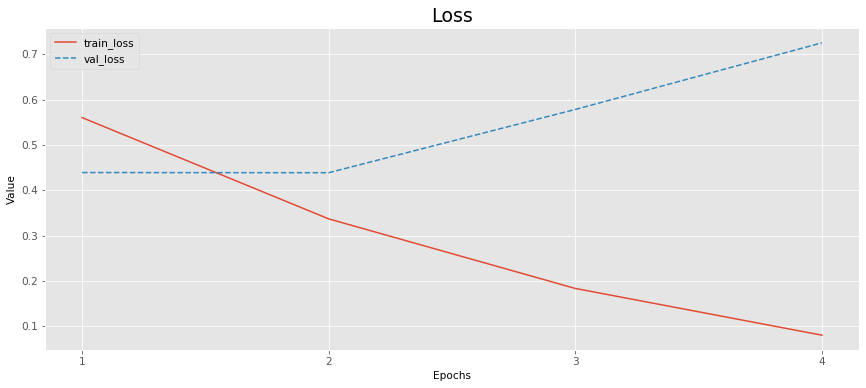

/usr/local/lib/python3.8/dist-packages/ml_things/plot_functions.py:409: DeprecationWarning: `magnify` needs to have value in [0,1]! `1.2` will be converted to `0.1` as default.
  warnings.warn(f'`magnify` needs to have value in [0,1]! `{magnify}` will be converted to `0.1` as default.',


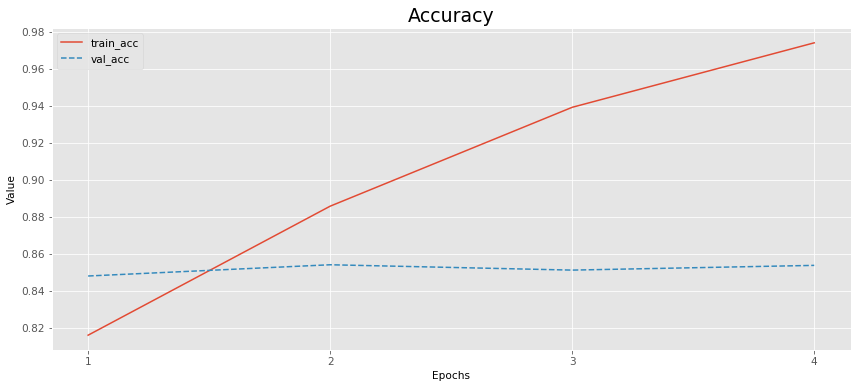

In [12]:
# AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8) # by default lr is 5e-5 and eps is 1e-8

# Total number of training steps is number of batches * number of epochs
# `train_dataloader` contains batches data so `len(train_dataloader)` gives us the number of batches
total_steps = len(train_dataloader) * epochs
# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Store the average loss after each epoch so we can plot them
all_loss = {'train_loss': [], 'val_loss': []}
all_acc = {'train_acc': [], 'val_acc': []}

# Loop through each epoch
print('Epoch')
for epoch in tqdm(range(epochs)):
    print()
    print('Training on batches...')
    # Perform one full pass over the training set
    train_labels, train_predict, train_loss = train(train_dataloader, optimizer, scheduler, device)
    train_acc = accuracy_score(train_labels, train_predict)

    print('Validation on batches...')
    # Get prediction form model on validation data
    valid_labels, valid_predict, val_loss = validation(valid_dataloader, device)
    val_acc = accuracy_score(valid_labels, valid_predict)

    # Print loss and accuracy values to see how training evolves
    print('  train_loss: %.5f - val_loss: %.5f - train_acc: %.5f - val_acc: %.5f' % (train_loss, val_loss, train_acc, val_acc))
    print()

    # Store the loss value for plotting the learning curve
    all_loss['train_loss'].append(train_loss)
    all_loss['val_loss'].append(val_loss)
    all_acc['train_acc'].append(train_acc)
    all_acc['val_acc'].append(val_acc)

# Plot loss curves
plot_dict(all_loss, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], use_title='Loss')
# Plot accuracy curves
plot_dict(all_acc, use_xlabel='Epochs', use_ylabel='Value', use_linestyles=['-', '--'], use_title='Accuracy')

## Evaluation

  0%|          | 0/844 [00:00<?, ?it/s]

               precision    recall  f1-score   support

    ITscience       0.91      0.85      0.88      3000
      culture       0.82      0.82      0.82      3000
      economy       0.83      0.95      0.89      3000
entertainment       0.89      0.96      0.92      3000
       health       0.88      0.91      0.89      3000
         life       0.78      0.70      0.74      3000
      politic       0.84      0.90      0.87      3000
       social       0.79      0.65      0.72      3000
        sport       0.93      0.95      0.94      3000

     accuracy                           0.85     27000
    macro avg       0.85      0.85      0.85     27000
 weighted avg       0.85      0.85      0.85     27000

Normalized confusion matrix


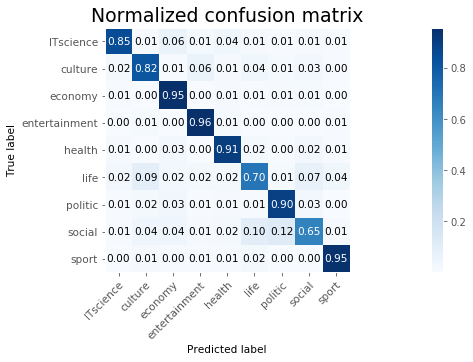

array([[8.51666667e-01, 1.00000000e-02, 6.03333333e-02, 1.16666667e-02,
        3.73333333e-02, 1.00000000e-02, 5.33333333e-03, 8.00000000e-03,
        5.66666667e-03],
       [2.16666667e-02, 8.17000000e-01, 6.00000000e-03, 6.33333333e-02,
        1.10000000e-02, 3.70000000e-02, 1.23333333e-02, 2.70000000e-02,
        4.66666667e-03],
       [7.33333333e-03, 3.33333333e-04, 9.52666667e-01, 3.33333333e-04,
        1.03333333e-02, 5.66666667e-03, 9.66666667e-03, 1.20000000e-02,
        1.66666667e-03],
       [4.00000000e-03, 1.26666667e-02, 1.33333333e-03, 9.57666667e-01,
        1.20000000e-02, 1.66666667e-03, 2.66666667e-03, 1.66666667e-03,
        6.33333333e-03],
       [9.00000000e-03, 3.33333333e-03, 2.60000000e-02, 2.33333333e-03,
        9.08000000e-01, 1.63333333e-02, 4.66666667e-03, 2.33333333e-02,
        7.00000000e-03],
       [2.30000000e-02, 9.03333333e-02, 2.33333333e-02, 2.03333333e-02,
        2.26666667e-02, 6.99333333e-01, 1.50000000e-02, 6.93333333e-02,
        3.6

In [13]:
# Get prediction form model on validation data
# This is where you should use your test data
true_labels, predictions_labels, avg_epoch_loss = validation(valid_dataloader, device)

# Create the evaluation report
evaluation_report = classification_report(true_labels, predictions_labels, labels=list(labels_ids.values()), target_names=label_names)
# Show the evaluation report
print(evaluation_report)

# Plot confusion matrix
plot_confusion_matrix(y_true=true_labels, y_pred=predictions_labels, classes=label_names, normalize=True, magnify=0.1)